Web Scraper

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL of the main Pokemon list page
base_url = "https://pokemondb.net"
list_url = f"{base_url}/pokedex/national"

response = requests.get(list_url)
soup = BeautifulSoup(response.text, 'html.parser')

pokemon_links = soup.select('.infocard a.ent-name')
pokemon_data = []

# Extract data
for link in pokemon_links:
    name = link.text
    url = f"{base_url}{link['href']}"

    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    entries_table = soup.find('h2', string='Pokédex entries')
    if entries_table:
        entries_table = entries_table.find_next('table')
        entries = [entry.text.strip() for entry in entries_table.select('td.cell-med-text')]
    else:
        entries = []
        print(f"No Pokédex entries found for {name}")

    # Find the stats table
    stats_table = soup.find('h2', string='Base stats').find_next('table')
    stats = {}
    for row in stats_table.select('tbody > tr'):
        stat_name = row.find('th').text.strip()
        stat_value = row.find('td', class_='cell-num').text.strip()
        stats[stat_name] = stat_value

    for entry in entries:
        pokemon_data.append({
            'entry': entry,
            'hp': stats['HP'],
            'attack': stats['Attack'],
            'defense': stats['Defense'],
            'sp_atk': stats['Sp. Atk'],
            'sp_def': stats['Sp. Def'],
            'speed': stats['Speed'],
        })

# Save to CSV
df = pd.DataFrame(pokemon_data)
df.to_csv('pokemon_entries_stats.csv', index=False)

No Pokédex entries found for Walking Wake
No Pokédex entries found for Iron Leaves
No Pokédex entries found for Dipplin
No Pokédex entries found for Poltchageist
No Pokédex entries found for Sinistcha
No Pokédex entries found for Okidogi
No Pokédex entries found for Munkidori
No Pokédex entries found for Fezandipiti
No Pokédex entries found for Ogerpon
No Pokédex entries found for Archaludon
No Pokédex entries found for Hydrapple
No Pokédex entries found for Gouging Fire
No Pokédex entries found for Raging Bolt
No Pokédex entries found for Iron Boulder
No Pokédex entries found for Iron Crown
No Pokédex entries found for Terapagos
No Pokédex entries found for Pecharunt


Randomize the order of the csv file to reduce bias


In [4]:
import pandas as pd
import numpy as np

df = pd.read_csv('pokemon_entries_stats.csv')

randomized_df = df.sample(frac=1, random_state=42)

randomized_df.to_csv('pokemon_entries_stats_randomized.csv', index=False)

Peek at the data

In [5]:
# Load the dataset
data_path = 'pokemon_entries_stats_randomized.csv'
data = pd.read_csv(data_path)

print(data.head())

                                               entry   hp  attack  defense  \
0  Its healthy appetite leads to visible growth s...   70      55       75   
1  The rich, fluffy fur that covers its body feel...  140      70       45   
2  It has eyes that can see through anything. It ...   80     120       79   
3  The fragrance of the garland on its head has a...   70      60       75   
4  An examination of its cells revealed the prese...   55      65       95   

   sp_atk  sp_def  speed  
0      45      65     60  
1      85      50     45  
2      95      79     70  
3     110      75     90  
4      95      45     85  


Preprocessing

In [10]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

data['processed_entries'] = data['entry'].apply(preprocess_text)
stats = data[['hp', 'attack', 'defense', 'sp_atk', 'sp_def', 'speed']]

stats_normalized = (stats - stats.mean()) / stats.std()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


GloVe Embeddings

In [12]:
!wget https://huggingface.co/stanfordnlp/glove/resolve/main/glove.42B.300d.zip
!unzip glove.42B.300d.zip



import numpy as np

# Help with contextual information
def load_glove_embeddings(filepath, embedding_dim):
    embeddings_index = {}
    with open(filepath, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    return embeddings_index

embedding_dim = 300
glove_path = f"glove.42B.300d.txt"
glove_embeddings = load_glove_embeddings(glove_path, embedding_dim)

--2024-05-06 22:01:08--  https://huggingface.co/stanfordnlp/glove/resolve/main/glove.42B.300d.zip
Resolving huggingface.co (huggingface.co)... 13.33.30.114, 13.33.30.76, 13.33.30.23, ...
Connecting to huggingface.co (huggingface.co)|13.33.30.114|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/stanfordnlp/glove/357baac33090f645e71e253b3295ee1b767c98a0336e9a1d99c77e9e33b43c4a?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27glove.42B.300d.zip%3B+filename%3D%22glove.42B.300d.zip%22%3B&response-content-type=application%2Fzip&Expires=1715290853&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxNTI5MDg1M319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9zdGFuZm9yZG5scC9nbG92ZS8zNTdiYWFjMzMwOTBmNjQ1ZTcxZTI1M2IzMjk1ZWUxYjc2N2M5OGEwMzM2ZTlhMWQ5OWM3N2U5ZTMzYjQzYzRhP3Jlc3BvbnNlLWNvbnRlbnQtZGlzcG9zaXRpb249KiZyZXNwb25zZS1jb250ZW50LXR5cGU9KiJ9XX0_&Signature=lNm7zlTAMBzyB

Split data

In [13]:
from sklearn.model_selection import train_test_split

# Splitting the dataset
train, temp = train_test_split(data, test_size=0.2, random_state=42)
valid, test = train_test_split(temp, test_size=0.5, random_state=42)

# Tokenize and pad sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train['processed_entries'])

train_sequences = tokenizer.texts_to_sequences(train['processed_entries'])
valid_sequences = tokenizer.texts_to_sequences(valid['processed_entries'])
test_sequences = tokenizer.texts_to_sequences(test['processed_entries'])

train_padded = pad_sequences(train_sequences, padding='post', maxlen=100)
valid_padded = pad_sequences(valid_sequences, padding='post', maxlen=100)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=100)

# Extract normalized stats for training and validation
train_stats = stats_normalized.loc[train.index].values
valid_stats = stats_normalized.loc[valid.index].values


Build Model

In [16]:
import tensorflow as tf

# Embedding layer
num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in tokenizer.word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


# RNN Model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=100, trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(6)  # One output for each stat
])

# Compile
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_squared_error'])

# Train
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(train_padded, train_stats, epochs=100, validation_data=(valid_padded, valid_stats), callbacks=[early_stopping])

Epoch 1/100
296/296 [==============================] - 14s 23ms/step - loss: 0.7202 - mean_squared_error: 0.8944 - val_loss: 0.6823 - val_mean_squared_error: 0.8150
Epoch 2/100
296/296 [==============================] - 5s 18ms/step - loss: 0.6320 - mean_squared_error: 0.7382 - val_loss: 0.6163 - val_mean_squared_error: 0.7092
Epoch 3/100
296/296 [==============================] - 5s 17ms/step - loss: 0.5613 - mean_squared_error: 0.6243 - val_loss: 0.5831 - val_mean_squared_error: 0.6360
Epoch 4/100
296/296 [==============================] - 5s 17ms/step - loss: 0.5024 - mean_squared_error: 0.5306 - val_loss: 0.5449 - val_mean_squared_error: 0.5828
Epoch 5/100
296/296 [==============================] - 5s 18ms/step - loss: 0.4547 - mean_squared_error: 0.4572 - val_loss: 0.5134 - val_mean_squared_error: 0.5521
Epoch 6/100
296/296 [==============================] - 5s 18ms/step - loss: 0.4118 - mean_squared_error: 0.3944 - val_loss: 0.4883 - val_mean_squared_error: 0.5033
Epoch 7/100
296

Loss curves

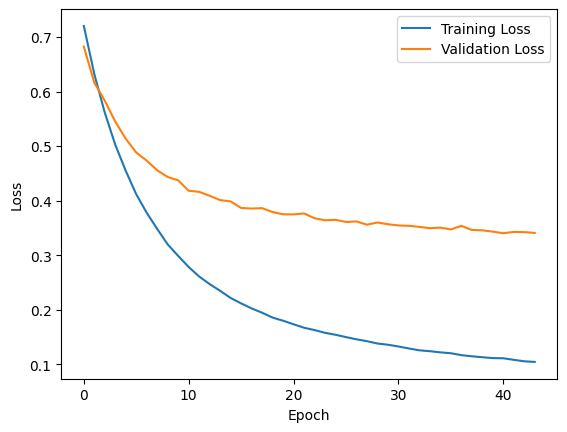

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Evaluate Model

In [18]:
test_loss, test_mae = model.evaluate(test_padded, stats_normalized.loc[test.index].values)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

37/37 [==============================] - 0s 8ms/step - loss: 0.3579 - mean_squared_error: 0.3663
Test Loss: 0.3579, Test MAE: 0.3663


Peek at Predictions

In [19]:
num_samples = 5
sample_indices = np.random.choice(len(test), num_samples, replace=False)

for idx in sample_indices:
    entry = test.iloc[idx]['entry']
    true_stats = stats.iloc[test.index[idx]]
    predicted_stats_normalized = model.predict(np.expand_dims(test_padded[idx], axis=0))
    predicted_stats_normalized = predicted_stats_normalized.reshape(-1)

    # Denormalize the predicted stats
    predicted_stats = np.round(predicted_stats_normalized * stats.std().values + stats.mean().values)

    print(f"Pokédex Entry: {entry}")
    print(f"True Stats: {true_stats.values}")
    print(f"Predicted Stats: {predicted_stats}")
    print("---")

1/1 [==============================] - 1s 1s/step
Pokédex Entry: Just like a plant, it uses photosynthesis. As a result, it is always enveloped in clear air.
True Stats: [ 65 110 130  60  65  95]
Predicted Stats: [ 67. 111. 131.  64.  64.  93.]
---
1/1 [==============================] - 0s 26ms/step
Pokédex Entry: After lowering its anchor, it waits for its prey. It catches large Wailord and drains their life-force.
True Stats: [ 70 131 100  86  90  40]
Predicted Stats: [85. 70. 59. 78. 60. 75.]
---
1/1 [==============================] - 0s 25ms/step
Pokédex Entry: ARIADOS’s feet are tipped with tiny hooked claws that enable it to scuttle on ceilings and vertical walls. This POKéMON constricts the foe with thin and strong silk webbing.
True Stats: [70 90 70 60 70 40]
Predicted Stats: [59. 70. 54. 67. 54. 48.]
---
1/1 [==============================] - 0s 26ms/step
Pokédex Entry: Miltank produces highly nutritious milk, so it’s been supporting the lives of people and other Pokémon since

Test With User Input

In [22]:
# Get user input for testing
while True:
    user_input = input("Enter a fake Pokédex entry (or 'quit' to exit): ")
    if user_input.lower() == 'quit':
        break

    user_input_processed = preprocess_text(user_input)
    user_input_sequence = tokenizer.texts_to_sequences([user_input_processed])
    user_input_padded = pad_sequences(user_input_sequence, padding='post', maxlen=100)

    # Make predictions on the user input
    user_input_predicted_normalized = model.predict(user_input_padded)
    user_input_predicted_normalized = user_input_predicted_normalized.reshape(-1)

    user_input_predicted = np.round(user_input_predicted_normalized * stats.std().values + stats.mean().values)

    print("Predicted Stats:")
    print("HP:", user_input_predicted[0])
    print("Attack:", user_input_predicted[1])
    print("Defense:", user_input_predicted[2])
    print("Special Attack:", user_input_predicted[3])
    print("Special Defense:", user_input_predicted[4])
    print("Speed:", user_input_predicted[5])
    print("---")

Enter a fake Pokédex entry (or 'quit' to exit): It fires rocks charged with electricity. Even if the rock isn’t fired that accurately, just grazing an opponent will cause numbness and fainting.
1/1 [==============================] - 0s 31ms/step
Predicted Stats:
HP: 75.0
Attack: 121.0
Defense: 90.0
Special Attack: 71.0
Special Defense: 81.0
Speed: 86.0
---
Enter a fake Pokédex entry (or 'quit' to exit): quit
